In [1]:
import numpy as np
import collections
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection, PatchCollection
import matplotlib.patches as patches
from tqdm.auto import tqdm

In [99]:
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
seq_lengths = np.array([int(l.split()[1]) for l in open('output/chr17_partial.lengths', 'r').read().splitlines()])
NUM_SEQ = len(seq_lengths)

In [4]:
partial_mums = [l.split() for l in open('output/chr17_partial.mums', 'r').read().splitlines()]
partial_mums = [(int(l[0]), np.array([int(v) if v else -1 for v in l[1].split(',')]), tuple(l[2].split(','))) for l in partial_mums]
mums = [m for m in partial_mums if np.all(m[1] != -1)]

In [5]:
def find_coll_blocks(mums, MAX_BREAK=10000):
    starts = np.array([m[1] for m in mums])
    mum_orders = starts.transpose().argsort()
    mum_gaps = []
    flips = set([])
    for i in range(mum_orders.shape[0]):
        cur = []
        for l in range(1, mum_orders.shape[1]):
            left, right = mum_orders[i][l-1], mum_orders[i][l]
            if mums[left][2][i] == mums[right][2][i]:
                if mums[left][2][i] == '+':
                    cur.append((left, right))
                else:
                    cur.append((right, left))
                    flips.add((right, left))
        mum_gaps.append(cur)
    common_gaps = set.intersection(*map(set, mum_gaps))
    left, right = zip(*common_gaps)
    left, right = set(list(left)), set(list(right))
    true_collinear_mums = sorted(list(left.intersection(right)))
    right_coll_mums = sorted(list(left.difference(set(true_collinear_mums)))) # have a right pair, but not a left
    left_coll_mums = sorted(list(right.difference(set(true_collinear_mums)))) # have a left pair, but not a right
    large_blocks = list(zip(right_coll_mums, left_coll_mums))
    ### find the longest stretches of collinear mums
    small_blocks = []
    for l, r in large_blocks:
        last = l
        for i in range(l, r):
            lens = np.full(len(mums[i][1]), mums[i][0])
            lens[(mums[i+1][1] < mums[i][1])] = mums[i+1][0] 
            gap_lens = np.abs(mums[i][1] - mums[i+1][1]) - lens
            if gap_lens.max() > MAX_BREAK and last < i:
                small_blocks.append((last, i))
                last = i + 1
        if last != r:
            small_blocks.append((last, r))
    return large_blocks, small_blocks, mum_gaps

In [6]:
def get_block_order(mums, blocks):
    starts = np.array([m[1] for m in mums])
    mum_orders = starts.transpose().argsort()
    ### get coll_block order
    coll_block_starts = [b[0] for b in blocks]
    coll_block_orders = []
    for i in range(mum_orders.shape[0]):
        poi = np.where(np.isin(mum_orders[i], coll_block_starts))[0]
        values = mum_orders[i][poi]
        poi = np.argsort(values)
        coll_block_orders.append(np.argsort(poi))
    return coll_block_orders

In [7]:
large_blocks, small_blocks, mum_gaps = find_coll_blocks(mums, MAX_BREAK=1000)
coll_block_order = get_block_order(mums, small_blocks)

In [8]:
def draw_synteny_outline_inv(genome_lengths, mums, outlines, inv_ranges=None, mum_color='red', inv_color='green'):
    def points_to_poly(points):
        starts, ends = tuple(zip(*points))
        points = starts + ends[::-1]
        return points
    fig, ax = plt.subplots()
    max_length = max(genome_lengths)
    for idx, g in enumerate(genome_lengths):
        ax.plot([0, g], [idx, idx], color='gray', alpha=0.2, linewidth=0.5)
    if inv_ranges:
        rects = []
        for i, s, e in inv_ranges:
            width = e - s
            height = 0.5  # since it's from i-0.5 to i+0.5
            rect = patches.Rectangle((s, i - 0.25), width, height)
            rects.append(rect)
        ax.add_collection(PatchCollection(rects, linewidth=0, facecolor='blue', alpha=0.3))
    polygons = []
    colors = []
    for _, (l, r) in enumerate(outlines):
        strands = mums[l][2]
        inverted = strands[0] == '-'
        points = []
        left, right = mums[l][1], mums[r][1] + mums[r][0]
        for idx, strand in enumerate(strands):
            points.append(((left[idx], idx), (right[idx], idx)))
            if not inverted and strand == '-':
                inverted = True
                if len(points) > 2:
                    polygons.append(points_to_poly(points[:-1]))
                    colors.append(mum_color)
                polygons.append(points_to_poly(points[-2:]))
                colors.append(inv_color)
                points = [points[-1]]
            elif inverted and strand == '+':
                inverted = False
                if len(points) > 2:
                    polygons.append(points_to_poly(points[:-1]))
                    colors.append(mum_color)
                polygons.append(points_to_poly(points[-2:]))
                colors.append(inv_color)
                points = [points[-1]]
        if len(points) >= 2:
            polygons.append(points_to_poly(points))
            colors.append(mum_color)
    ax.add_collection(PolyCollection(polygons, linewidths=0, alpha=0.5, edgecolors=colors, facecolors=colors))
    
    ax.yaxis.set_ticks(range(len(genome_lengths)))
    ax.tick_params(axis='y', which='both',length=0)
    ax.yaxis.set_ticklabels([])
    ax.set_xlabel('bp')
    ax.set_ylabel('sequences')
    ax.set_ylim(0, len(genome_lengths)-1)
    ax.set_xlim(0, max_length)
    return fig, ax

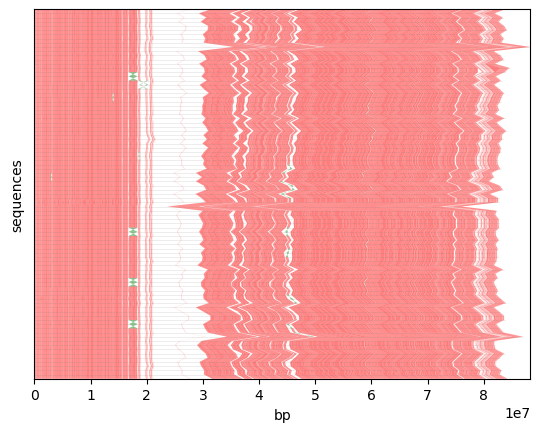

In [9]:
fig, ax = draw_synteny_outline_inv(seq_lengths, mums, small_blocks)

### look at mostly conserved mum gaps

In [10]:
### start with gaps that appear in everything but 1
gap_counter = collections.Counter(sum(mum_gaps, []))
mum_gap_sets = [set(m) for m in mum_gaps]
missing_gaps = [t for t, c in gap_counter.items() if c == NUM_SEQ - 1]
outlier_without_gap = [[i for i, s in enumerate(mum_gap_sets) if g not in s][0] for g in missing_gaps]
broken_mum_pairs = [g for o, g in zip(outlier_without_gap, missing_gaps) if o == np.bincount(outlier_without_gap).argmax()]

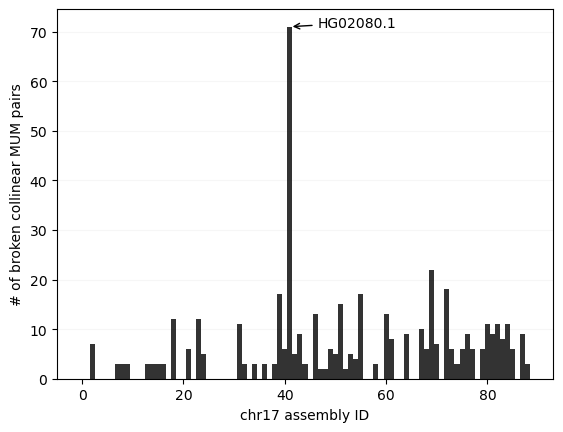

In [100]:
fig, ax = plt.subplots()
ax.set_xlabel('chr17 assembly ID')
ax.set_ylabel('# of broken collinear MUM pairs')
counts = np.bincount(outlier_without_gap)
x = np.arange(90)
ax.stairs(counts, x-0.5, baseline=0, fill=True, color='black', alpha=0.8, linewidth=0,zorder=2)
ax.annotate('HG02080.1', 
            xy=(np.bincount(outlier_without_gap).argmax(), np.bincount(outlier_without_gap).max()),
            xytext=(20, -0), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

# Add light horizontal grid lines
ax.grid(axis='y', linestyle='-', alpha=0.1, zorder=0)

In [34]:
def draw_synteny(ax, genome_lengths, mums, highlight, mum_color=(0.8, 0.8, 0.8), inv_color='green'):
    def points_to_poly(points):
        starts, ends = tuple(zip(*points))
        points = starts + ends[::-1]
        return points        
    # fig, ax = plt.subplots()
    max_length = max(genome_lengths)
    for idx, g in enumerate(genome_lengths):
        ax.plot([0, g], [idx, idx], color='gray', alpha=0.2, linewidth=0.5)
    polygons = []
    colors = []
    color=mum_color
    # inv_color=(0.8, 0.8, 0.8)
    for idx in highlight:
        (l, starts, strands) = mums[idx]
        inverted = strands[0] == '-'
        points = []
        for idx, (x, strand) in enumerate(zip(starts, strands)): 
            if x == -1:
                if len(points) > 2:
                    polygons.append(points_to_poly(points))
                    colors.append(color)
                points = []
                continue
            points.append(((x, idx), (x + l, idx)))
            if not inverted and strand == '-':
                inverted = True
                if len(points) > 2:
                    polygons.append(points_to_poly(points[:-1]))
                    colors.append(color)
                polygons.append(points_to_poly(points[-2:]))
                colors.append(inv_color)
                points = points[-1:]
            elif inverted and strand == '+':
                inverted = False
                if len(points) > 2:
                    polygons.append(points_to_poly(points[:-1]))
                    colors.append(color)
                polygons.append(points_to_poly(points[-2:]))
                colors.append(inv_color)
                points = points[-1:]
        if len(points) >= 2:
            polygons.append(points_to_poly(points))
            colors.append(color)
    # return ax, polygons, colors
    ax.add_collection(PolyCollection(polygons, linewidths=.1, alpha=1, edgecolors=colors, facecolors=colors))
    ax.yaxis.set_ticks(range(len(genome_lengths)))
    ax.tick_params(axis='y', which='both',length=0)
    ax.yaxis.set_ticklabels([])
    ax.set_xlabel('bp')
    ax.set_ylabel('sequences')
    # ax.set_ylim(40, 42)
    ax.set_xlim(0, max_length)
    # fig.set_tight_layout(True)
    # fig.set_dpi(200)
    # fig.set_size_inches(10, 6)
    # return fig, ax
    return ax

Text(0.5, 0, 'genomic position')

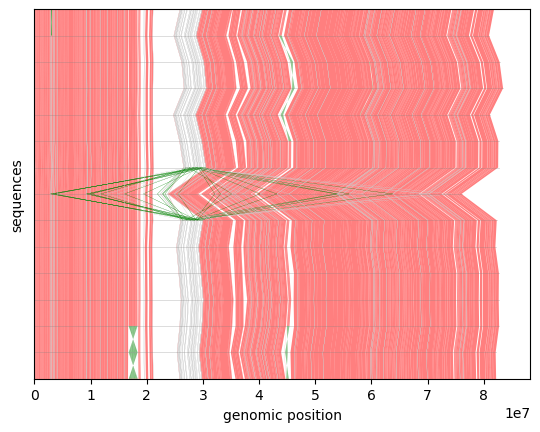

In [102]:
fig, ax = draw_synteny_outline_inv(seq_lengths, mums, large_blocks)
ax = draw_synteny(ax, seq_lengths, mums, set([item for pair in broken_mum_pairs for item in pair]), mum_color=(0.8,0.8,0.8), inv_color='green')
# ax.set_xlim(problem_region[0] - 100000, problem_region[1] + 100000)
ax.set_ylim(41 - 7, 41 + 7);
# ax.set_xlim(0.9e7, 3.1e7)
ax.set_xlabel('genomic position')

### look for all but one MUMs

Text(20, 0, 'HG02080.1')

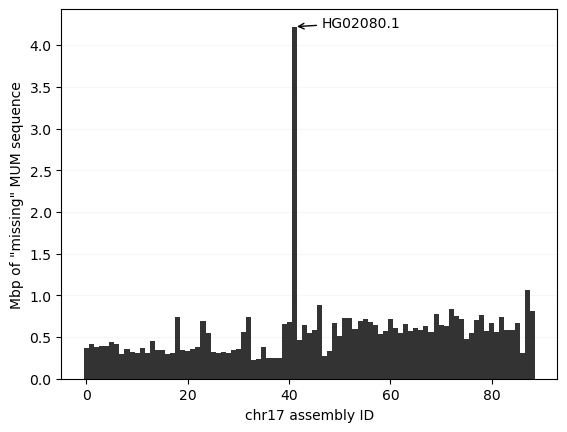

In [104]:
fig, ax = plt.subplots()
# Add light horizontal grid lines
ax.grid(axis='y', linestyle='-', alpha=0.1, zorder=0)
data = np.bincount(np.where(np.array([l[1] for l in partial_mums]) == -1)[1], weights = [l[0]/1e6 for l in partial_mums])
x = np.arange(90)
ax.stairs(data, x-0.5, baseline=0, fill=True, color='black', alpha=0.8, linewidth=0,zorder=2)
ax.set_xlabel('chr17 assembly ID')

ax.set_ylabel('Mbp of "missing" MUM sequence')
ax.annotate('HG02080.1', 
            xy=(data.argmax(), data.max()),
            xytext=(20, -0), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))


In [38]:
# Get ID of the sequence with the most missing MUMs
problem_sequence = np.bincount(np.where(np.array([l[1] for l in partial_mums]) == -1)[1], weights = [l[0] for l in partial_mums]).argmax()

In [39]:
# Find interblock regions that are present in all sequences

def common_interblock_regions(coll_block_order, min_seq=80):
    mum_gaps = []
    flips = set([])
    for i in range(len(coll_block_order)):
        cur = []
        for l in range(1, len(coll_block_order[0])):
            left, right = coll_block_order[i][l-1], coll_block_order[i][l]
            if mums[left][2][i] == mums[right][2][i]:
                if mums[left][2][i] == '+':
                    cur.append((left, right))
                else:
                    cur.append((right, left))
                    flips.add((right, left))
        mum_gaps.append(cur)
    gap_counter = collections.Counter(sum(mum_gaps, []))
    missing_gaps = [t for t, c in gap_counter.items() if c >= min_seq]
    # common_gaps = set.intersection(*map(set, mum_gaps))
    return missing_gaps

shared_interblock = common_interblock_regions(coll_block_order)
shared_interblock = list(sorted(shared_interblock))
shared_interblock_set = set(shared_interblock)
print(len(shared_interblock), '/', len(coll_block_order[0]), 'shared')

874 / 878 shared


In [40]:
# Get the coords of the shared interblock regions in each sequence
intermum_regions = []
broken_region_count = {(min(l,r), (max(l,r))) : {} for l, r in shared_interblock}
for idx, order in enumerate(coll_block_order):
    curgaps = []
    for i in range(len(order) - 1):
        left, right = order[i], order[i+1]
        if (left, right) in shared_interblock_set or (right, left) in shared_interblock_set:
            ## find the right most coord of the left and leftmoost coord of the right
            coords_left = max(mums[small_blocks[left][0]][1][idx], mums[small_blocks[left][1]][1][idx] + mums[small_blocks[left][1]][0])
            coords_right = min(mums[small_blocks[right][0]][1][idx], mums[small_blocks[right][1]][1][idx] + mums[small_blocks[right][1]][0])
            if coords_right > coords_left:
                curgaps.append((left, right, coords_left, coords_right))
                broken_region_count[(min(left,right), (max(left,right)))][idx] = 0
    intermum_regions.append(curgaps)

In [41]:
### finds the interblock region where the partial mums appear

partial_mums_of_interest = [m for m in partial_mums if m[1][problem_sequence] == -1]
for m in tqdm(partial_mums_of_interest):
    if m[1][problem_sequence] == -1:
        for idx, offset in enumerate(m[1]):
            if offset != -1:
                for i, (l, r, s, e) in enumerate(intermum_regions[idx]):
                    if (offset >= s) and (offset + m[0] <= e):
                        broken_region_count[(min(l,r), (max(l,r)))][idx] += 1
                        break    

  0%|          | 0/20356 [00:00<?, ?it/s]

In [42]:
broken_region_avg_count = {k : np.mean(list(v.values())) for k, v in broken_region_count.items()}
[(k, v) for k,v in broken_region_avg_count.items() if v == max(broken_region_avg_count.values())][0]

(left,right), _ = [(k, v) for k,v in broken_region_avg_count.items() if v == max(broken_region_avg_count.values())][0]
region_coords = {idx : [i for i, (l, r, _, _) in enumerate(intermum_regions[idx]) if (l == left and r == right)] for idx in range(len(intermum_regions))}
region_coords = {k : intermum_regions[k][v[0]] if len(v) == 1 else None for k,v in region_coords.items()}

/scratch4/blangme2/vshiv/conda/envs/basic/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch4/blangme2/vshiv/conda/envs/basic/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'genomic position')

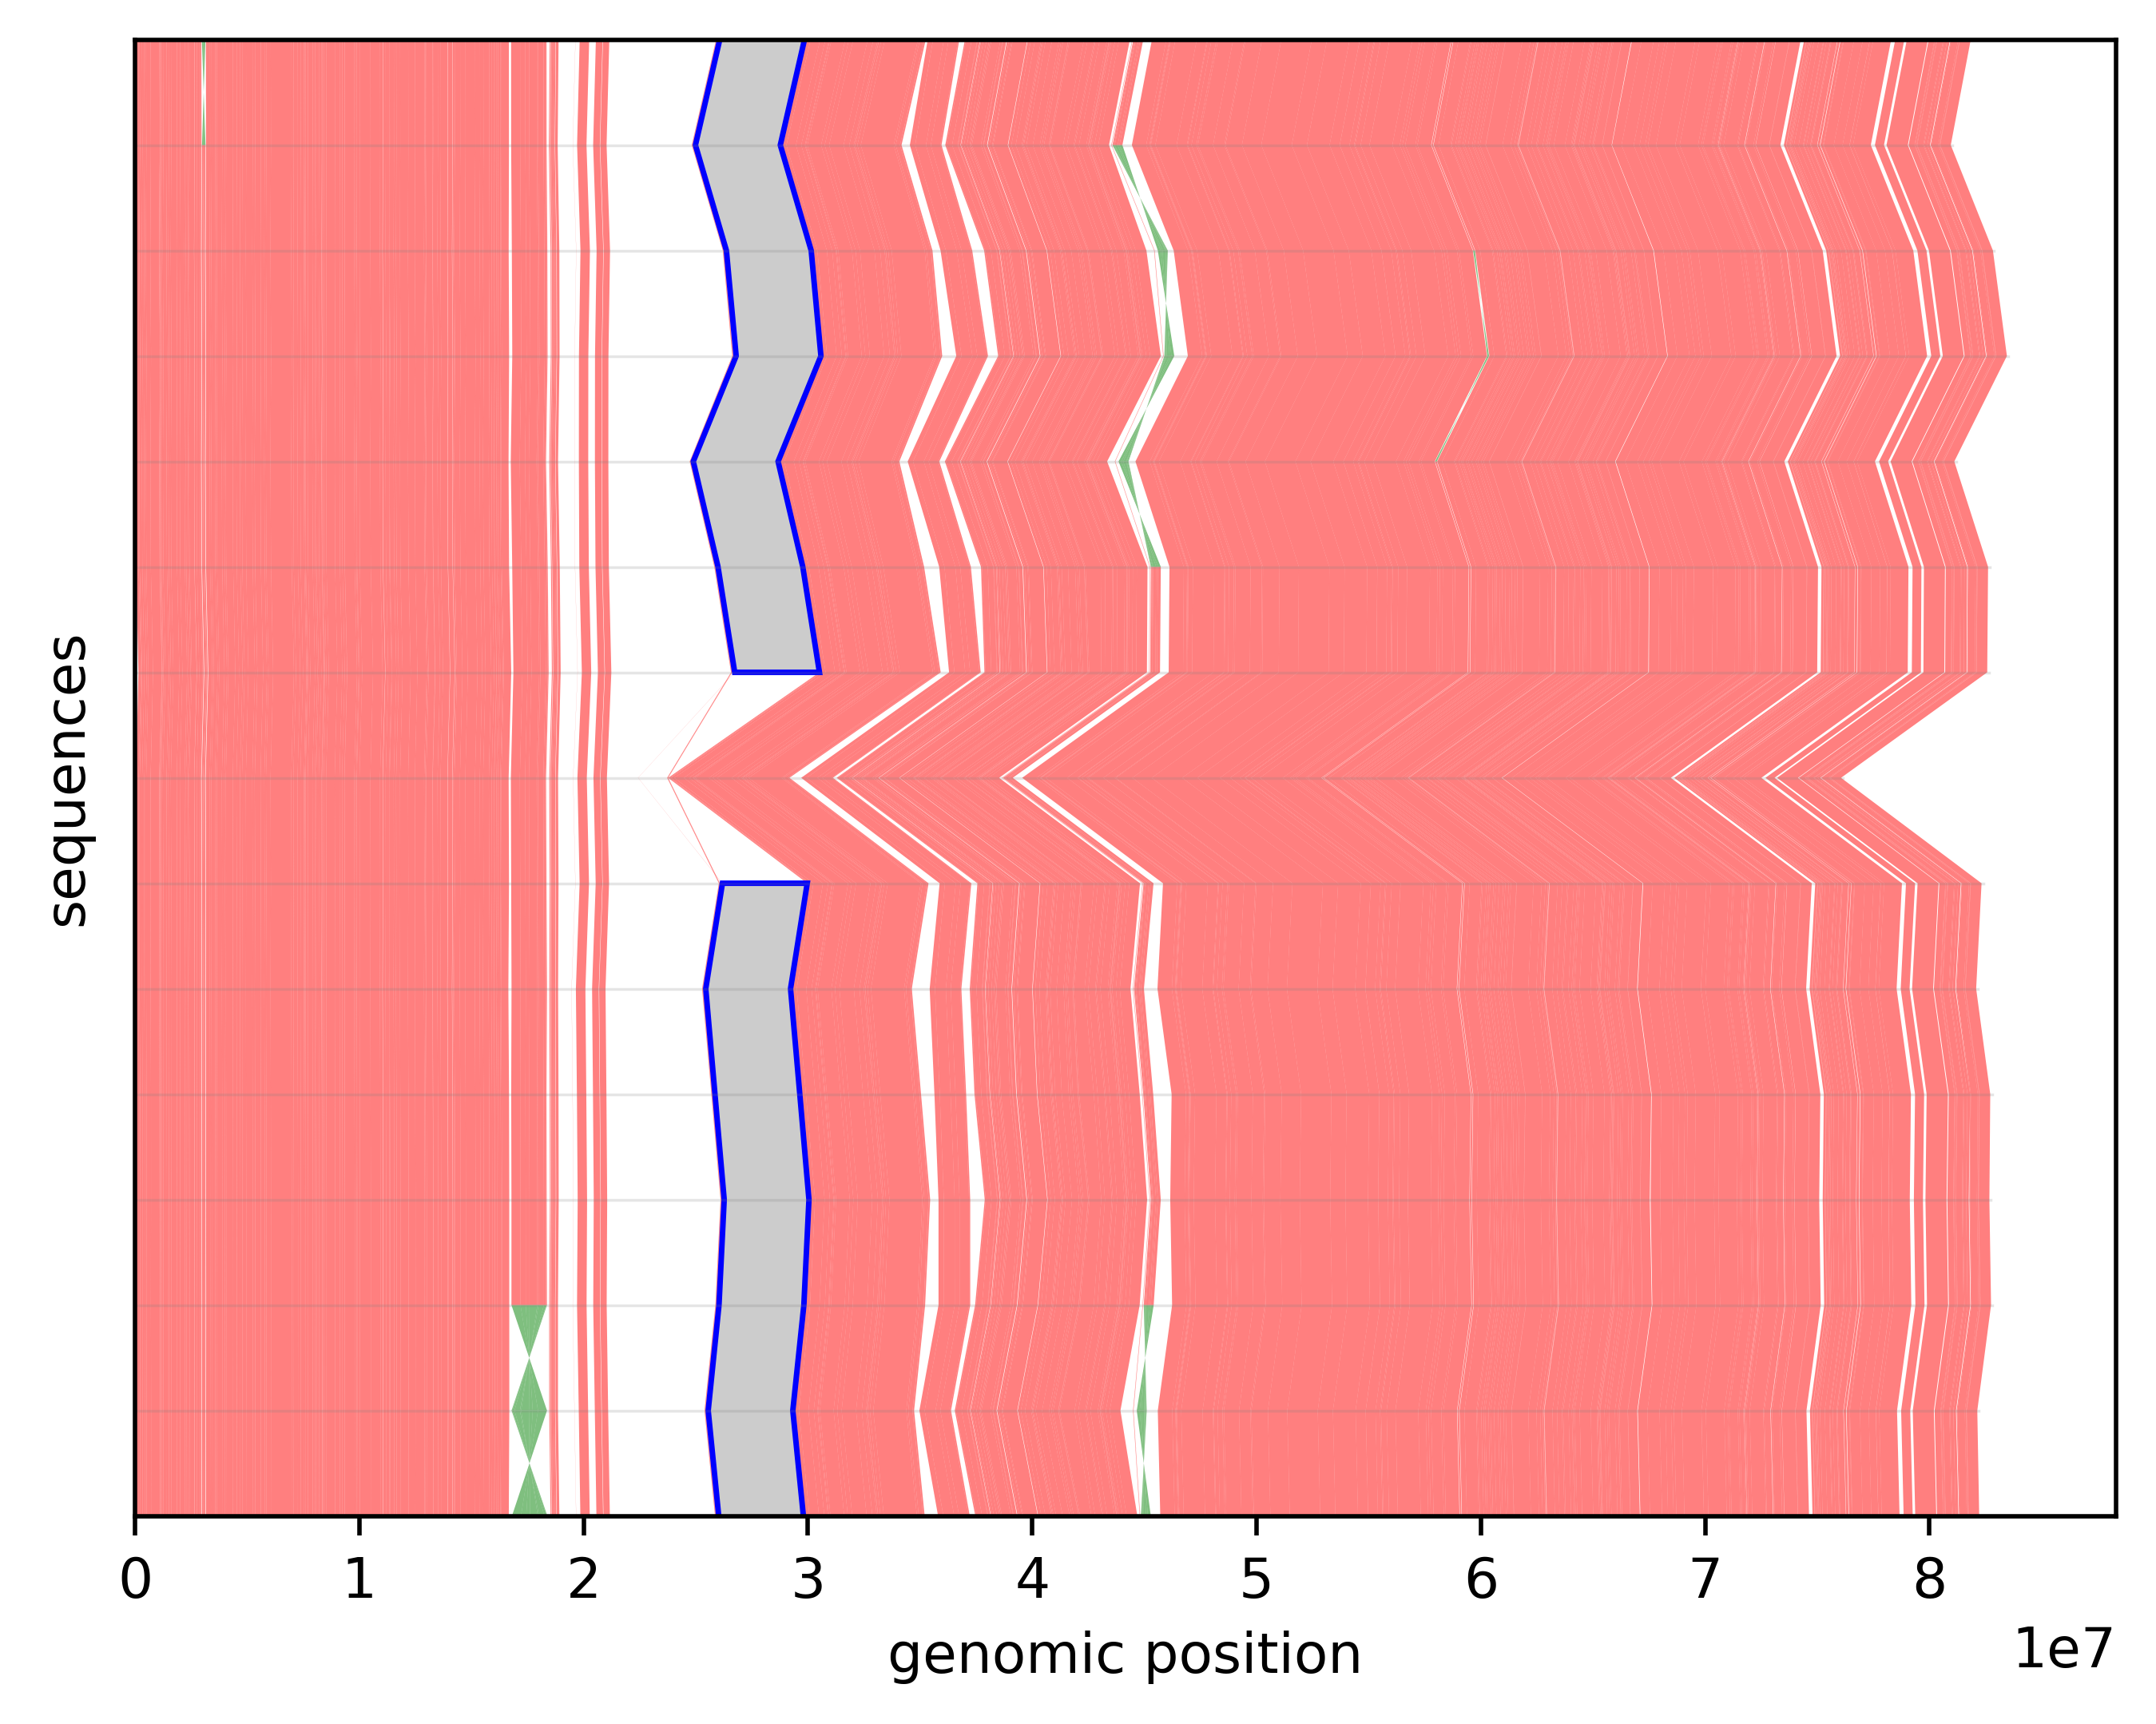

In [106]:
fig, ax = draw_synteny_outline_inv(seq_lengths, mums, large_blocks)
# Draw the region with the most partial mums
# before 41
points = [((region_coords[i][2], i), (region_coords[i][3], i)) for i in range(problem_sequence)]
starts, ends = tuple(zip(*points))
points = starts + ends[::-1]
polygon = patches.Polygon(points, closed=True, linewidth=1, edgecolor='blue', facecolor=(0.8,0.8,0.8))
ax.add_patch(polygon)
# after 41
points = [((region_coords[i][2], i), (region_coords[i][3], i)) for i in range(problem_sequence+1,len(seq_lengths))]
starts, ends = tuple(zip(*points))
points = starts + ends[::-1]
polygon = patches.Polygon(points, closed=True, linewidth=1, edgecolor='blue', facecolor=(0.8,0.8,0.8))
ax.add_patch(polygon)

ax.set_ylim(41 - 7, 41 + 7);
ax.set_xlabel('genomic position')